<a href="https://www.bigdatauniversity.com"><img src = "https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width = 400, align = "center"></a>

<h1 align=center><font size = 5> Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2018-11-30 01:23:19--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2018-11-30 01:23:19 (10.5 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
seaborn                   0.9.0                    py35_0    anaconda


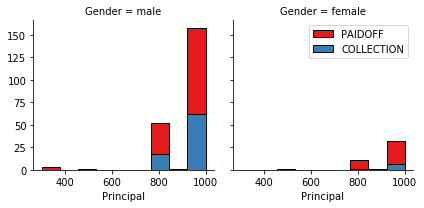

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

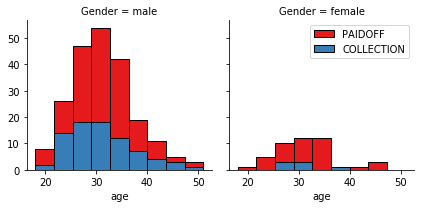

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

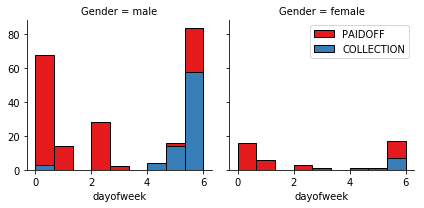

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

In [21]:
# Train Test Split: Train size 80% , Test size 20%

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [22]:
# Let's calculate accuracy of KNN for different k (number of clusters)

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([ 0.67142857,  0.65714286,  0.71428571,  0.68571429,  0.75714286,
        0.71428571,  0.78571429,  0.75714286,  0.75714286])

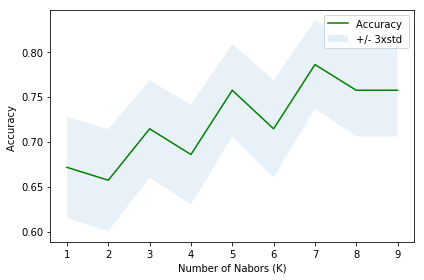

In [23]:
# Let's plot model accuracy for Different number of Neighbors

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

# k=7 is the best k for the model

In [24]:
# Train model for k=7 clusters

k=7
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [25]:
# Prediction

yhat = neigh.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [26]:
# Accuracy Evaluation

print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, neigh.predict(X_test)))

Train set Accuracy:  0.807971014493
Test set Accuracy:  0.785714285714


In [27]:
# jaccard index for accuracy evaluation

jaccard_similarity_score(y_test, neigh.predict(X_test))

0.7857142857142857

In [28]:
# F1 score for accuracy evaluation

print (classification_report(y_test, neigh.predict(X_test)))

             precision    recall  f1-score   support

 COLLECTION       0.50      0.40      0.44        15
    PAIDOFF       0.84      0.89      0.87        55

avg / total       0.77      0.79      0.78        70



In [29]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[ 6  9]
 [ 6 49]]


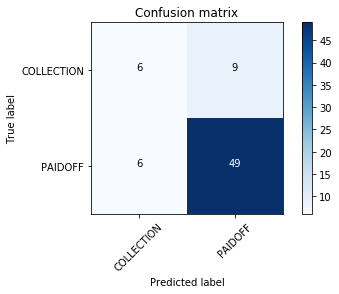

In [30]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, neigh.predict(X_test), labels=['COLLECTION','PAIDOFF'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='Confusion matrix')

# Decision Tree

In [31]:
# Train Test Split was done in KNN setup

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [32]:
# Decision Tree Model

from sklearn.tree import DecisionTreeClassifier

loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 5)
loanTree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [33]:
# Training feature matrix

loanTree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [34]:
# Prediction

yhat = loanTree.predict(X_test)

In [35]:
# Evaluation

print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, yhat))

DecisionTrees's Accuracy:  0.642857142857


In [36]:
# jaccard index for accuracy evaluation

#from sklearn.metrics import jaccard_similarity_score

jaccard_similarity_score(y_test, loanTree.predict(X_test))

0.6428571428571429

In [37]:
# F1 score for accuracy evaluation

#from sklearn.metrics import classification_report, confusion_matrix

print (classification_report(y_test, yhat))

             precision    recall  f1-score   support

 COLLECTION       0.33      0.67      0.44        15
    PAIDOFF       0.88      0.64      0.74        55

avg / total       0.76      0.64      0.67        70



Confusion matrix, without normalization
[[10  5]
 [20 35]]


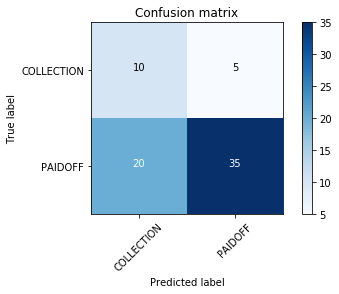

In [38]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, yhat, labels=['COLLECTION','PAIDOFF'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='Confusion matrix')

# Support Vector Machine

In [39]:
# Train Test Split was done in KNN setup

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [40]:
# SVM with Sccikit-learn using radial basis functions (rbf) as the kernel function

from sklearn import svm

clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [41]:
# Prediction 

yhat = clf.predict(X_test)

In [42]:
# Evaluation

print("SVM's Accuracy: ", metrics.accuracy_score(y_test, yhat))

SVM's Accuracy:  0.742857142857


In [43]:
# jaccard index for accuracy

jaccard_similarity_score(y_test, clf.predict(X_test))

0.74285714285714288

In [44]:
# F1 score for accuracy evaluation

print (classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

 COLLECTION       0.36      0.27      0.31        15
    PAIDOFF       0.81      0.87      0.84        55

avg / total       0.72      0.74      0.73        70



Confusion matrix, without normalization
[[ 4 11]
 [ 7 48]]


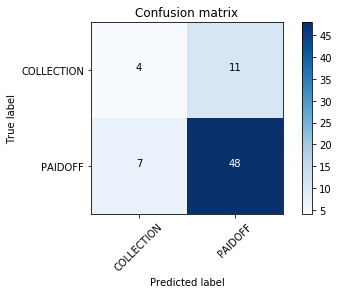

In [45]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, clf.predict(X_test), labels=['COLLECTION','PAIDOFF'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='Confusion matrix')

# Logistic Regression

In [46]:
# Logistic Regression with Scikit-learn

from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [47]:
# Prediction

yhat = LR.predict(X_test)

In [48]:
# Evaluation

print("Logistic Regression's Accuracy: ", metrics.accuracy_score(y_test, yhat))

Logistic Regression's Accuracy:  0.685714285714


In [49]:
# jaccard index for accuracy

jaccard_similarity_score(y_test, LR.predict(X_test))

0.68571428571428572

In [50]:
# F1 score for accuracy evaluation

print (classification_report(y_test, LR.predict(X_test)))

             precision    recall  f1-score   support

 COLLECTION       0.18      0.13      0.15        15
    PAIDOFF       0.78      0.84      0.81        55

avg / total       0.65      0.69      0.67        70



Confusion matrix, without normalization
[[ 4 11]
 [ 7 48]]


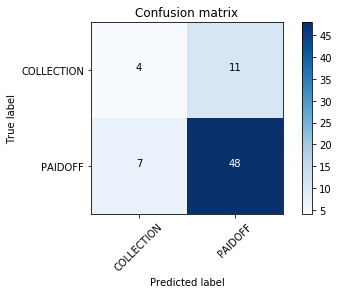

In [51]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, clf.predict(X_test), labels=['COLLECTION','PAIDOFF'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='Confusion matrix')

### Logarithmic loss - logloss metric evaluation

In [52]:
yhat_test = LR.predict(X_test)
yhat[0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [53]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob[0:5]

array([[ 0.5 ,  0.5 ],
       [ 0.45,  0.55],
       [ 0.31,  0.69],
       [ 0.34,  0.66],
       [ 0.32,  0.68]])

In [54]:
from sklearn.metrics import log_loss

log_loss(y_test, yhat_prob)

0.57722876094796538

# Model Evaluation using Test set

In [55]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [56]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2018-11-30 01:24:08--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2018-11-30 01:24:08 (565 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [57]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


# Test set:  pre-processing, feature selection and one hot encoding

In [58]:
# Convert to date time object.
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

#Feature binarization of the column effective_date.
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

# Convert categorical data to numerical values.
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

# One hot encoding the education column and concatenate to the feature matrix.
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)

# Drop the "Master or above" column.
Feature.drop(['Master or Above'], axis = 1,inplace=True)

X_eval = Feature
y_eval = test_df['loan_status'].values

In [59]:
X_eval[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [60]:
# Normalize Data
X_eval = preprocessing.StandardScaler().fit(X_eval).transform(X_eval)

In [61]:
print ('Train set:', X_train.shape,  y_train.shape)
print ('Eval set:', X_eval.shape,  y_eval.shape)

Train set: (276, 8) (276,)
Eval set: (54, 8) (54,)


In [62]:
# Initialise the Report DataFrame

cols = ['Algorithm','Jaccard','F1-score', 'LogLoss']
report = pd.DataFrame(columns=cols)

# Evaluation metrics

In [63]:
# k-Nearest Neighborhoods

print('KNN: Jaccard Index={}\n'.format(
    jaccard_similarity_score(y_eval, neigh.predict(X_eval))))

print (classification_report(y_eval, neigh.predict(X_eval)))

KNN: Jaccard Index=0.6666666666666666

             precision    recall  f1-score   support

 COLLECTION       0.25      0.14      0.18        14
    PAIDOFF       0.74      0.85      0.79        40

avg / total       0.61      0.67      0.63        54



In [64]:
# Append indexes to the report Dataframe

report = report.append({\
    'Algorithm': 'KNN',
    'Jaccard': 0.67,
    'F1-score': 0.63,
    'LogLoss': np.nan}, ignore_index=True)

In [65]:
# Decision Tree

print('Decision Tree: Jaccard Index={}\n'.format(
    jaccard_similarity_score(y_eval, loanTree.predict(X_eval))))

print (classification_report(y_eval, loanTree.predict(X_eval)))


Decision Tree: Jaccard Index=0.7592592592592593

             precision    recall  f1-score   support

 COLLECTION       0.52      0.86      0.65        14
    PAIDOFF       0.94      0.72      0.82        40

avg / total       0.83      0.76      0.77        54



In [66]:
# Append indexes to the report Dataframe

report = report.append({\
    'Algorithm': 'Decision Tree',
    'Jaccard': 0.76,
    'F1-score': 0.77,
    'LogLoss': np.nan}, ignore_index=True)

In [67]:
# Support Vector Machine

print('Support Vector Machine: Jaccard Index={}\n'.format(
    jaccard_similarity_score(y_eval, clf.predict(X_eval))))

print (classification_report(y_eval, clf.predict(X_eval)))


Support Vector Machine: Jaccard Index=0.7962962962962963

             precision    recall  f1-score   support

 COLLECTION       0.80      0.29      0.42        14
    PAIDOFF       0.80      0.97      0.88        40

avg / total       0.80      0.80      0.76        54



In [68]:
# Append indexes to the report Dataframe

report = report.append({\
    'Algorithm': 'SVM',
    'Jaccard': 0.80,
    'F1-score': 0.76,
    'LogLoss': np.nan}, ignore_index=True)

In [69]:
# Logistic Regression

print('Logistic Regression: Jaccard Index={}\n'.format(
    jaccard_similarity_score(y_eval, LR.predict(X_eval))))

print (classification_report(y_eval, LR.predict(X_eval)))

Logistic Regression: Jaccard Index=0.7407407407407407

             precision    recall  f1-score   support

 COLLECTION       0.50      0.07      0.12        14
    PAIDOFF       0.75      0.97      0.85        40

avg / total       0.69      0.74      0.66        54



In [70]:
# log_loss metric evaluation

y_predict = LR.predict(X_eval)
y_proba = LR.predict_proba(X_eval)

log_loss(y_predict, y_proba)

0.52437909299190111

In [71]:
# Append indexes to the report Dataframe

report = report.append({\
    'Algorithm': 'Logistic Regression',
    'Jaccard': 0.74,
    'F1-score': 0.66,
    'LogLoss': 0.52}, ignore_index=True)

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

In [72]:
report

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.67,0.63,NaN
1,Decision Tree,0.76,0.77,NaN
2,SVM,0.80,0.76,NaN
3,Logistic Regression,0.74,0.66,0.52


## Want to learn more?

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: [SPSS Modeler](http://cocl.us/ML0101EN-SPSSModeler).

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at [Watson Studio](https://cocl.us/ML0101EN_DSX)


<hr>
Copyright &copy; 2018 [Cognitive Class](https://cocl.us/DX0108EN_CC). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).​

### Thanks for completing this lesson!

Notebook created by: <a href = "https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>